# 군집분석 : 타깃마케팅을 위한 K-평균 군집화

- 머신러닝의 비지도 학습 방식을 이해한다.
- 군집화와 K-평균 알고리즘을 이해한다.
- 군집 분석을 이용하여 소비자 군집을 생성할 수 있다.


In [42]:
''' Google Colab 사용시 '''
'''
from google.colab import drive
drive.mount('/content/drive/')
data_path='/content/drive/My Drive/UST/BigData/Data/'
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive/')\ndata_path='/content/drive/My Drive//UST/BigData/Data/'\n"

* 군집생성 feature: 마지막 주문후 경과일(Elapsed Days), 주문횟수(Freq), 주문 총액(Total Amount)

### 1) 데이터 수집

In [2]:
import pandas as pd
import math

In [3]:
data_path="~/KISTI/UST/"
retail_df = pd.read_excel(data_path+'Online_Retail.xlsx')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 2) 데이터 준비 및 탐색

In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- invoiceNo: 6자리 정수로 이루어진 송장 번호. ‘C’로 시작하는 것은 취소 주문
- StockCode: 제품 고유의 품목 코드
- Description: 제품 설명
- Quantity: 주문 수량
- InvoiceDate: 주문 날짜와 시간
- UnitPrice: 제품 단가(£, 영국 파운드화)
- CustomerID: 주문 고객 번호
- Country: 주문 고객의 국적


In [5]:
# 오류 데이터 정제
retail_df = retail_df[retail_df['Quantity'] > 0]   #Quantity가 음수인 것 제거
retail_df = retail_df[retail_df['UnitPrice'] > 0]  #UnitPrice가 음수인 것도 제거
retail_df = retail_df[retail_df['CustomerID'].notnull()] # CustomerID가 없는 데이터는 분석에 사용할 수 없으므로 제거

# 'CustomerID' 자료형을 정수형으로 변환
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [6]:
retail_df.info()
print(retail_df.isnull().sum())
print(retail_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.3+ MB
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
(397884, 8)


In [7]:
# 중복 레코드 제거
retail_df.drop_duplicates(inplace=True) # 특정 컬럼의 중복만을 고려할 수도 있으나, 여기서는 전체 행의 중복 여부를 판단

print(retail_df.shape) #작업 확인용 출력

(392692, 8)


#### - 제품 수, 거래건 수, 고객 수 탐색

In [8]:
pd.DataFrame([{'Product':len(retail_df['StockCode'].value_counts()),
              'Transaction':len(retail_df['InvoiceNo'].value_counts()),
              'Customer':len(retail_df['CustomerID'].value_counts())}],
             columns = ['Product', 'Transaction', 'Customer'],
            index = ['counts'])

,Product,Transaction,Customer
counts,3665,18532,4338


In [9]:
retail_df['Country'].value_counts() #각각의 값이 몇번 나왔는지 세어줌

Country
United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


In [10]:
# 주문금액 컬럼 추가
retail_df['SaleAmount'] = retail_df['UnitPrice'] * retail_df['Quantity']

retail_df.head() #작업 확인용 출력

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### - 고객의 주문횟수(Freq), 주문 총액(Total Amount), 마지막 주문후 경과일(Elapsed Days) 구하기
다음 3가지의 feature로 clustering을 수행: Freq_log, SaleAmount_log', ElapsedDays_log

In [11]:
# 마케팅에 이용하기 위해 고객의 주문 횟수, 주문 총액, 그리고 마지막 주문 후 며칠이 지났는지에 대한 정보를 추출
# 각 고객의 정보를 추출하기 위해 CustomerID를 기준으로 그룹을 만들고 groupby( ),
# 주문 횟수를 계산하기 위해 InvoiceNo의 개수(count)를 구함
# 주문 금액(SaleAmount)의 총액(sum)을 구하고,
# 주문일(InvoiceDate)중에서 가장 최근 날짜(max)를 찾아
# 새로운 데이터프레임 객체인 customer_df를 생성

aggregations = {
    'InvoiceNo':'count',  #고객의 주문 횟수
    'SaleAmount':'sum',   #주문 총액
    'InvoiceDate':'max'   #마지막 주문 일자
}

customer_df = retail_df.groupby('CustomerID').agg(aggregations)
customer_df = customer_df.reset_index()

customer_df.head()  #작업 확인용 출력

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


* C.f.) Pandas Groupby 함수의 동작 (images from towarddatascience.com / ichi.pro)

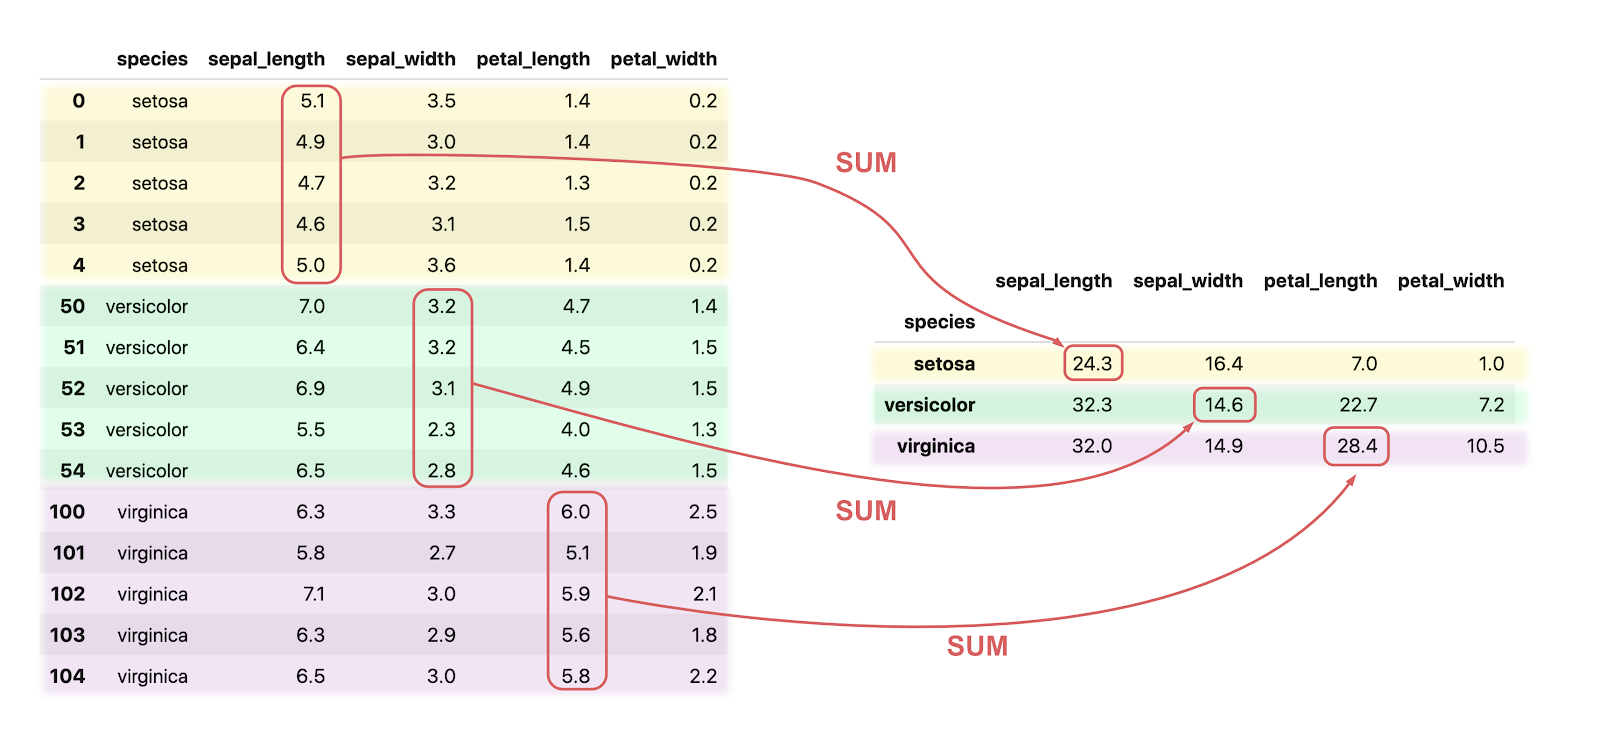

* Pandas 그룹(group) 객체 생성 및 집계(agg) 연산
  * agg() 함수: 여러개의 함수를 여러 열에 적용하기

    - 모든열에 여러 함수를 매핑 : group객체.agg([함수1,함수2,함수3,…])
    - 각 열마다 다른 함수를 매핑 : group객체.agg({‘열1’: 함수1, ‘열2’:함수2, …})

  * Reference: https://yganalyst.github.io/data_handling/Pd_13/

* c.f) agg 함수의 사용 예

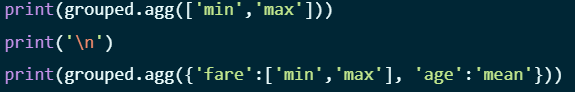

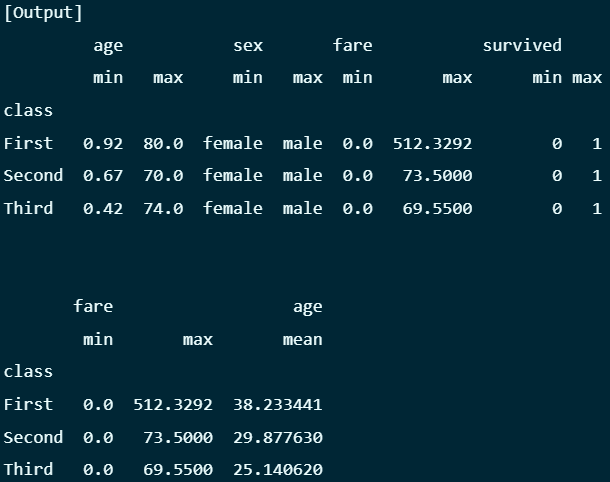

In [12]:
# 데이터프레임의 컬럼 추출 및 분석용 데이터 생성하기
# 컬럼이름 바꾸기
customer_df = customer_df.rename(columns = {'InvoiceNo':'Freq', 'InvoiceDate':'ElapsedDays'})

customer_df.head() #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


#### - 마지막 구매후 경과일 계산하기

In [13]:
import datetime

customer_df['ElapsedDays'] = datetime.datetime(2011,12,10) - customer_df['ElapsedDays'] #‘기준 날짜 - 마지막 구매일’을 계산

customer_df.head() #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,325 days 13:59:00
1,12347,182,4310.00,2 days 08:08:00
2,12348,31,1797.24,75 days 10:47:00
3,12349,73,1757.55,18 days 14:09:00
4,12350,17,334.40,310 days 07:59:00


In [14]:
customer_df['ElapsedDays'] = customer_df['ElapsedDays'].apply(lambda x: x.days+1)  # pandas  apply() - 내가 정의한 함수를 컬럼에 적용할때 , 여기서는 한줄짜리 lamda 함수 적용
customer_df.head() #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,326
1,12347,182,4310.00,3
2,12348,31,1797.24,76
3,12349,73,1757.55,19
4,12350,17,334.40,311


#### - 현재 데이터 값의 분포 확인하기

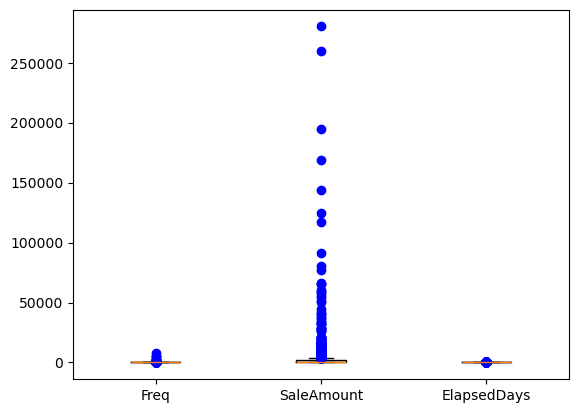

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq'], customer_df['SaleAmount'], customer_df['ElapsedDays']], sym='bo') #customer_df의 3개 컬럼으로 박스플롯 3개를 그림
plt.xticks([1, 2, 3], ['Freq', 'SaleAmount','ElapsedDays' ])

plt.show()

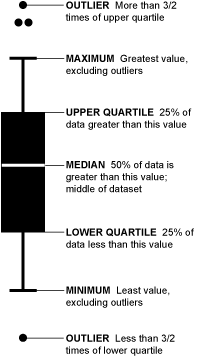

* box plot
 - Max: 상위 사분위수 (Q3) 에서 1.5 IQR을 더한값을 초과하지 않는 가장 큰 수
 - IQR (Interquartile Range):
  Q3 (75th Percentile) - Q1 (25th Percentile)
 - 계산 방식:
      - Upper Bound=Q3+1.5*IQR
      - Max Value=Upper Bound 이하의 가장 큰 값

 -  Outlier의 결정:
      - 이상값은 위의 Upper Bound를 초과하거나, Lower Bound (Q1 - 1.5 IQR)를 미만인 데이터 포인트

#### - 데이터 값의 왜곡(치우침)을 줄이기 위한 작업 : 로그 함수로 분포 조정

In [16]:
import numpy as np

# 컬럼 값에 로그 함수log1p( )를 취한 값을 새 컬럼으로 추가하여 저장
# numpy.log1p 함수는 (요소 단위로) 입력 어레이에 대해 자연로그 log(1 + x) 값을 반환
customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])

customer_df.head()  #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
0,12346,1,77183.60,326,0.693147,11.253955,5.789960
1,12347,182,4310.00,3,5.209486,8.368925,1.386294
2,12348,31,1797.24,76,3.465736,7.494564,4.343805
3,12349,73,1757.55,19,4.304065,7.472245,2.995732
4,12350,17,334.40,311,2.890372,5.815324,5.743003


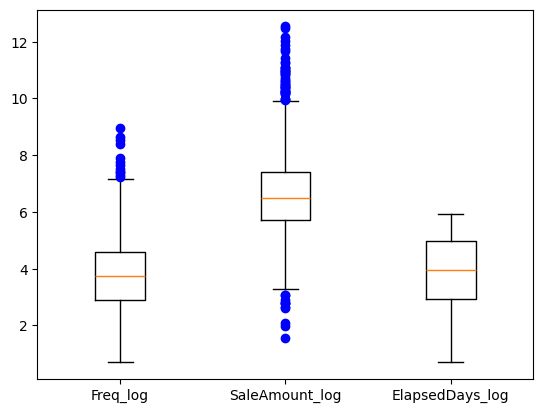

In [17]:
# 조정된 데이터 분포를 다시 박스플롯으로 확인하기
fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq_log'], customer_df['SaleAmount_log'],customer_df['ElapsedDays_log']], sym='bo')
plt.xticks([1, 2, 3], ['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'])
plt.show()

### 3) 모델 구축 : K-평균 군집화 모델

In [18]:
#K-평균 군집화 모델링을 위한 KMeans 임포트

from sklearn.cluster import KMeans

In [19]:
X_features = customer_df[['Freq_log', 'SaleAmount_log', 'ElapsedDays_log']].values #행들의 데이터만

In [20]:
# 정규 분포로 다시 스케일링하기
from sklearn.preprocessing import StandardScaler

#X_features를 정규 분포로 스케일링StandardScaler( ).fit_transform하여 X_features_ scaled에 저장
X_features_scaled = StandardScaler().fit_transform(X_features)

### - 최적의 k 찾기 (1) 엘보우 방법
* 왜곡: 클러스터의 중심점과 클러스터내의 데이터 거리차이의 제곱값의 합(오차제곱합, SSE - Sum of Squared Error)
* 클러스터의 개수 k의 변화에 따른 왜곡의 변화를 그래프로 그려보면 그래프가 꺾이는 지점인 엘보우(elbow, 팔꿈치)가 나타나는데 그 지점의 k를 최적의 k로 선택
* 클러스터 개수를 1로 두고 계산한 SSE보다 2로 두고 계산한 SSE가 작다면 2개의 클러스터가 더 적합함을 의미
* 하지만 SSE가 너무 작아도 안됨. 왜냐하면 클러스터의 개수가 증가할수록 centroid와 데이터 포인트 간의 거리가 작아져, cost가 계속해서 감소하기 때문

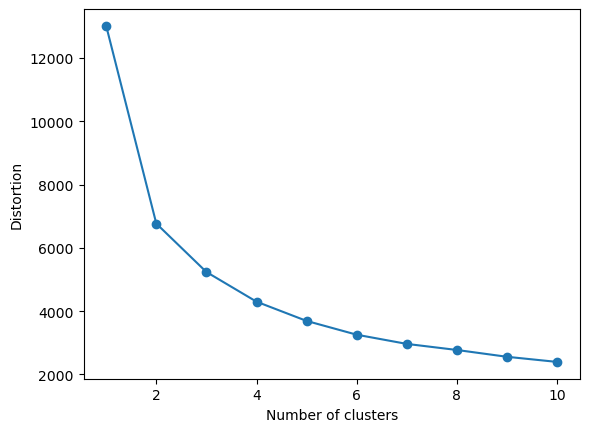

In [21]:
distortions = []

# K-평균 모델을 생성하고 KMeans( ) 훈련하는 fit( ) 작업을 클러스터의 개수인 1부터 10 까지 반복하면서
# 왜곡 값inertia_을 (데이터 중심점으로 부터 데이터포인트간의 거리) 리스트distortions에 저장
for i in range(1, 11):
    kmeans_i = KMeans(n_clusters=i, random_state=0)  # 모델 생성
    kmeans_i.fit(X_features_scaled)   # 모델 훈련
    distortions.append(kmeans_i.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [22]:
kmeans = KMeans(n_clusters=3, random_state=0) # 모델 생성

# 모델 학습과 결과 예측(클러스터 레이블 생성)
Y_labels = kmeans.fit_predict(X_features_scaled)

In [23]:
customer_df['ClusterLabel'] = Y_labels

customer_df.head()  #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,2
1,12347,182,4310.00,3,5.209486,8.368925,1.386294,1
2,12348,31,1797.24,76,3.465736,7.494564,4.343805,2
3,12349,73,1757.55,19,4.304065,7.472245,2.995732,2
4,12350,17,334.40,311,2.890372,5.815324,5.743003,0


## 4) 결과 분석 및 시각화

### - 최적의 k 찾기 (2) 실루엣 계수에 따른 각 클러스터의 비중 시각화 함수 정의
* 클러스터내에 있는 데이터가 얼마나 조밀하게 모여있는지 측정하는 그래프 도구
* 클러스터 응집력 a(i): 데이터 i가 해당 클러스터내의 데이터와 얼마나 가까운가를 나타내는 지표
* 클러스터 분리도 b(i): 가장 가까운 다른클러스터 내의 데이터와 얼마나 떨어져 있는지를 나타내는 지표
* -1에서 1사이의 값을 가지며 1에 가까울수록 좋은 군집화를 의미


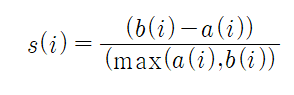

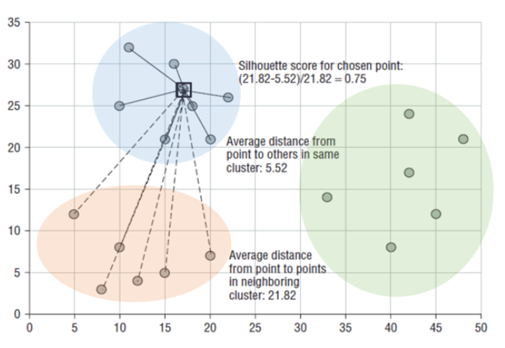

In [24]:
from matplotlib import cm

#실루엣 계수 계산에 사용할 silhouette_ score, silhouette_samples를 임포트
from sklearn.metrics import silhouette_score, silhouette_samples

def silhouetteViz(n_cluster, X_features):

    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)

    silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean') #sklearn.metrics.silhouette_samples 각 샘플에 대한 실루엣 계수를 계산

    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    # 클러스터 마다 순회하며
    for c in range(n_cluster):
        c_silhouettes = silhouette_values[Y_labels == c] # 그 클러스터 안에 있는 모든 데이터들에 대해 silhouette 값을 가져옴
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouettes,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouettes)

    silhouette_avg = np.mean(silhouette_values)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title('Number of Cluster : '+ str(n_cluster)+'\n' \
              + 'Silhouette Score : '+ str(round(silhouette_avg,3)))
    plt.yticks(y_ticks, range(n_cluster))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

* 위 그래프들은 각 군집별 실루엣 스코어를 나타내고, 실루엣 계수를 시각화한 것임
* 각 군집별 샘플의 실루엣 계수를 아래에서 위로 오름차순으로 쭉 이어서 만든 것
* 실루엣 스코어를 보며 최적의 군집 개수를 결정(클수록 좋고 보통 0.5이상이면 아주 좋음), 이때 개별 군집의 실루엣 계수의 평균값의 편차가 작은 게 좋다.
* 군집 수 최적화는 이런식으로 시각화를 이용

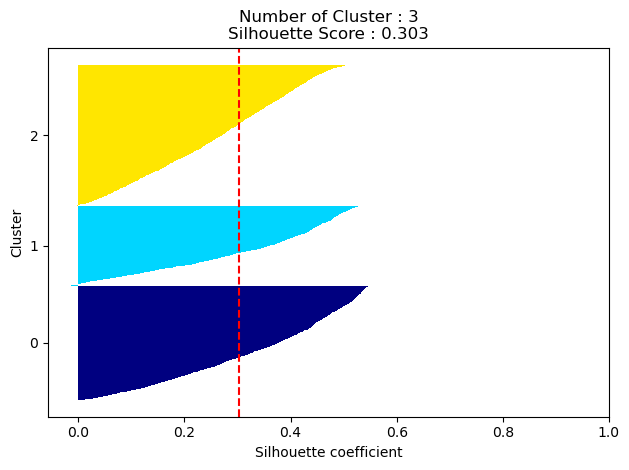

In [25]:
silhouetteViz(3, X_features_scaled) #클러스터 3개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

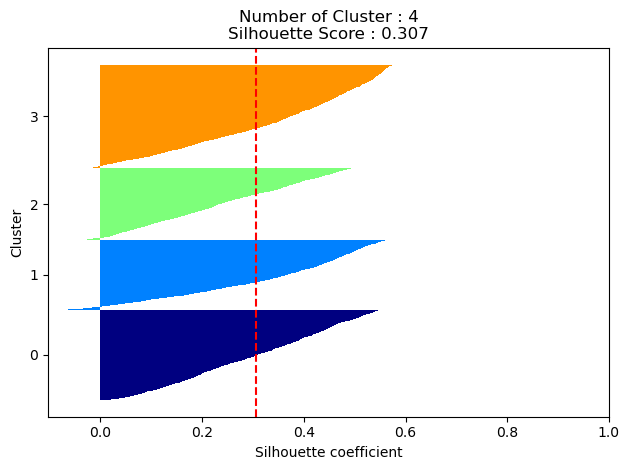

In [26]:
silhouetteViz(4, X_features_scaled) #클러스터 4개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

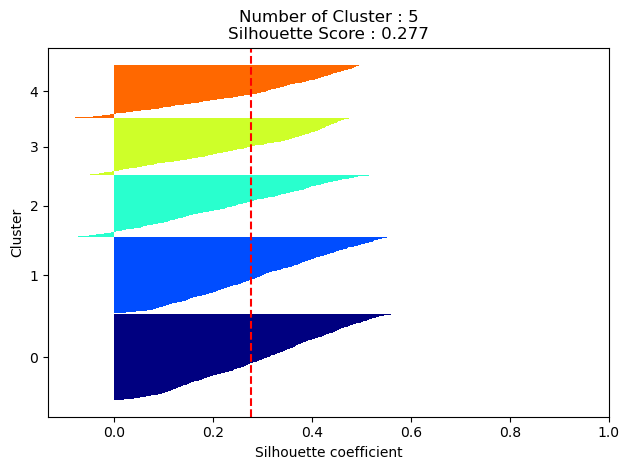

In [27]:
silhouetteViz(5, X_features_scaled) #클러스터 5개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

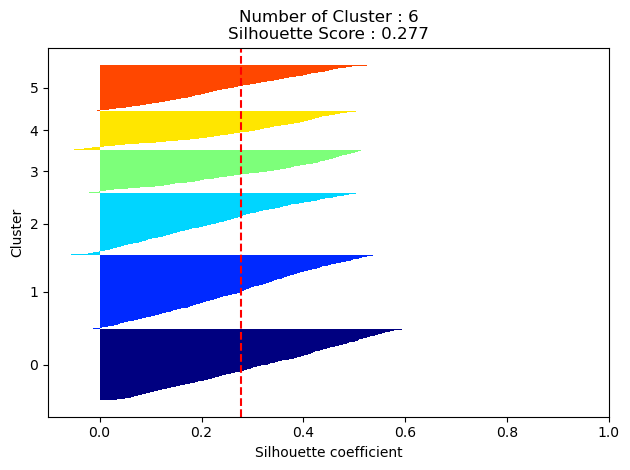

In [28]:
silhouetteViz(6, X_features_scaled) #클러스터 6개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

### - 클러스터 수에 따른 클러스터 데이터 분포의 시각화 함수 정의

In [29]:
def clusterScatter(n_cluster, X_features):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i) / n_cluster) #클러스터의 색상 설정
        c_colors.append(c_color)
        #클러스터의 데이터 분포를 동그라미로 시각화
        plt.scatter(X_features[Y_labels == i,0], X_features[Y_labels == i,1], # x: 0-th feature (Freq_log), y: 1-th feature (SaleAmount_log)
                     marker='o', color=c_color, edgecolor='black', s=50,      # x, y 중 한 특징을 (ElapsedDays_log)로 바꾸어서 살펴봐도 됨
                     label='cluster '+ str(i))

    #각 클러스터의 중심점을 삼각형으로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1],
                    marker='^', color=c_colors[i], edgecolor='w', s=200)

    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

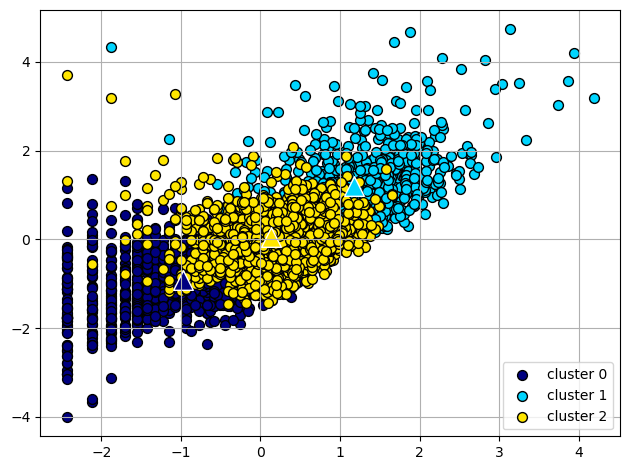

In [30]:
clusterScatter(3, X_features_scaled) #클러스터 3개인 경우의 클러스터 데이터 분포 시각화

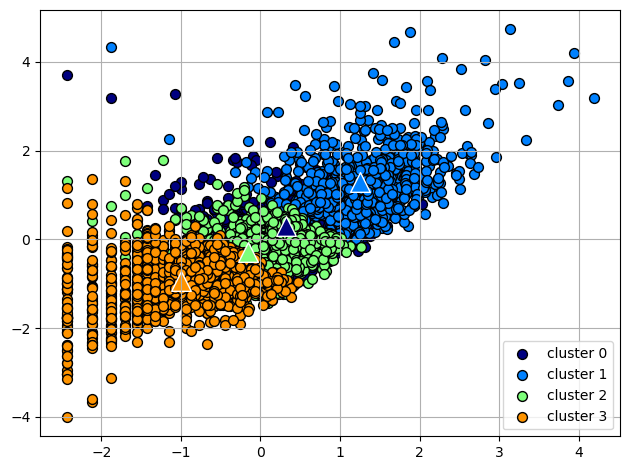

In [31]:
clusterScatter(4, X_features_scaled)  #클러스터 4개인 경우의 클러스터 데이터 분포 시각화

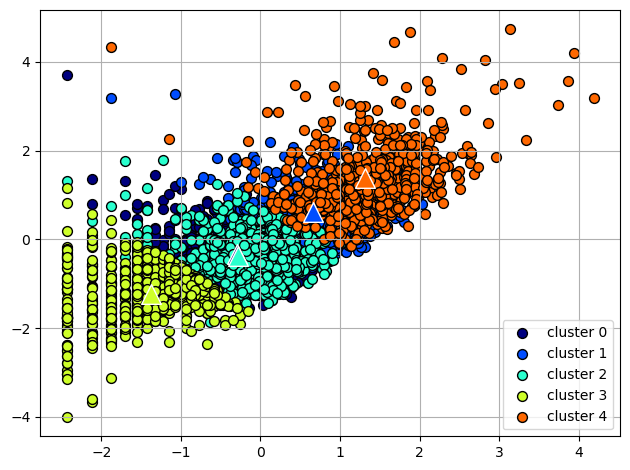

In [32]:
clusterScatter(5, X_features_scaled)  #클러스터 5개인 경우의 클러스터 데이터 분포 시각화

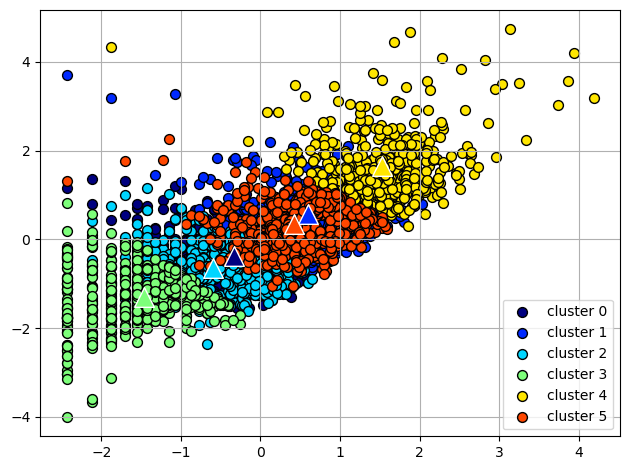

In [33]:
clusterScatter(6, X_features_scaled)  #클러스터 6개인 경우의 클러스터 데이터 분포 시각화

### 결정된 k를 적용하여 최적의 K-mans 모델 완성

In [34]:
best_cluster = 4

kmeans = KMeans(n_clusters=best_cluster, random_state=0)
Y_labels = kmeans.fit_predict(X_features_scaled)

In [35]:
customer_df['ClusterLabel'] = Y_labels

customer_df.head()   #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,0
1,12347,182,4310.00,3,5.209486,8.368925,1.386294,1
2,12348,31,1797.24,76,3.465736,7.494564,4.343805,0
3,12349,73,1757.55,19,4.304065,7.472245,2.995732,1
4,12350,17,334.40,311,2.890372,5.815324,5.743003,3


#### - ClusterLabel이 추가된 데이터를 파일로 저장

In [36]:
customer_df.to_csv(data_path+'Online_Retail_Customer_Cluster.csv')

## << 클러스터 분석하기 >>

### 1) 각 클러스터의 고객수

In [37]:
customer_df.groupby('ClusterLabel')['CustomerID'].count()

ClusterLabel
0    1167
1     900
2     931
3    1340
Name: CustomerID, dtype: int64

### 2) 각 클러스터의 특징

In [38]:
customer_cluster_df = customer_df.drop(['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'],axis=1, inplace=False)

In [39]:
customer_cluster_df

,CustomerID,Freq,SaleAmount,ElapsedDays,ClusterLabel
0,12346,1,77183.60,326,0
1,12347,182,4310.00,3,1
2,12348,31,1797.24,76,0
3,12349,73,1757.55,19,1
4,12350,17,334.40,311,3
...,...,...,...,...,...
4333,18280,10,180.60,278,3
4334,18281,7,80.82,181,3
4335,18282,12,178.05,8,2
4336,18283,721,2045.53,4,1


In [40]:
# 주문 1회당 평균 구매금액 : SaleAmountAvg
customer_cluster_df['SaleAmountAvg'] = customer_cluster_df['SaleAmount']/customer_cluster_df['Freq']

customer_cluster_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,ClusterLabel,SaleAmountAvg
0,12346,1,77183.60,326,0,77183.600000
1,12347,182,4310.00,3,1,23.681319
2,12348,31,1797.24,76,0,57.975484
3,12349,73,1757.55,19,1,24.076027
4,12350,17,334.40,311,3,19.670588


In [41]:
# 클러스터별 분석
customer_cluster_df.drop(['CustomerID'],axis=1, inplace=False).groupby('ClusterLabel').mean()

,Freq,SaleAmount,ElapsedDays,SaleAmountAvg
ClusterLabel,,,,
0,74.443873,1453.809907,106.652956,106.760512
1,275.008889,6901.516111,14.833333,94.322099
2,41.978518,643.460173,20.473684,31.243547
3,14.347761,283.721501,184.191791,43.337452
